<a href="https://colab.research.google.com/github/JamieCDev20/GAM705/blob/main/705Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

### Imports

###Too big and annoying

In [1]:
!pip install pyquaternion
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###This is fine

In [2]:
import numpy as np
import os
from pyquaternion import Quaternion
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from random import random as r
import matplotlib.pyplot as plt
import time
from google.colab import drive

In [3]:
drive.mount('/content/drive')
rootPath = '/content/drive/MyDrive/AnimAI/'

aiOutPath = f'{rootPath}aiCheckpoints'
animFilePath = f'{rootPath}AnimTextFiles'
os.makedirs(aiOutPath, exist_ok=True)


Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### File Reader

In [61]:
class AnimFileReader():
  ## "#" breaks between nodes | ":" breaks between values

  def __init__(self, _path):
    self.path = _path
    self.animData = np.array(float)
    self.realData = np.array(float)
    self.jointCount = 0
    self.frameCount = 0
    self.__ReadAnim__(self.path)
    self.frameSize = self.jointCount * 14
    self.realSize = self.jointCount * 7

  def __ReadAnim__(self, path):
    file = open(path, 'r')
    overallData = file.read()
    overallData = overallData.split("SS")
    
    del overallData[0]

    jointCount = len(overallData)
    frameCount = len(overallData[0].split('#')[0].split(':')) - 1
    
    self.jointCount = jointCount
    self.frameCount = frameCount - 20

    dataLayer = np.array(float)

    trainingData = np.array(float)
    
    for j in range(10, frameCount-10):
      for i in range(0, jointCount):

        rots = overallData[i].split('#')[0].split(':')
        poss = overallData[i].split('#')[1].split(':')

        del rots[0]
        del poss[0]

        #quat maths:
        # b / a = c
        # c = how to get from a to b
        # c * a = b

        temp = rots[j].split(',')
        lastRot = rots[j-1].split(',')

        a = Quaternion(lastRot)
        b = Quaternion(temp)
        c = b / a

        dataLayer = np.append(dataLayer, temp)

        temp = rots[j+1].split(',')
        self.realData = np.append(self.realData, temp)
        
        for k in range(4):
          dataLayer = np.append(dataLayer, c[k])
        
        temp = poss[j].split(',')
        lastPos = poss[j-1].split(',')

        posDif = [0, 1, 2]

        dataLayer = np.append(dataLayer, temp)

        temp = poss[j+1].split(',')
        self.realData = np.append(self.realData, temp)

        for k in range(3):
          dataLayer = np.append(dataLayer, float(temp[k]) - float(lastPos[k]))


        #print(dataLayer.shape)
      dataLayer = np.delete(dataLayer, 0)
      trainingData = np.append(trainingData, dataLayer);
      dataLayer = np.array(float)
      #print("Completed: ", j + 1)

    #print("Total its: ", (i + 1) * (j + 1))
    
    trainingData = np.delete(trainingData, 0)

    self.realData = np.delete(self.realData, 0)
    
    #print(trainingData.shape)
    #print(trainingData[0])
    
    self.animData = trainingData;
   

# Curve GAN Training

##Training Vars

In [ ]:
def Func(x):
  return 0.08 * (x-25)**2 - 10

In [ ]:
genNoiseDim = 1

In [ ]:
batchSize = 64
iterations = 10000

testSeed = np.random.uniform(0, 50, [batchSize, genNoiseDim])

holder = []
for i in range(batchSize):
  holder.append(Func(testSeed[i]))

trueData = np.array(holder)

##Networks

Discriminator

In [ ]:
discriminator = Sequential([
    Input(shape=(2)),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])
#discriminator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

Generator

In [ ]:
generator = Sequential([
      Input(shape=(genNoiseDim)),
      Dense(50, activation='relu', use_bias = True),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])
#generator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

##Training

In [ ]:
def GenerateRealBatch(size, _noise):
  batch = []
  for i in range(size):
    batch.append(Func(_noise[i]))
  return np.array(batch)

In [ ]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

genOp = tf.keras.optimizers.Adam(1e-4)
discOp = tf.keras.optimizers.Adam(1e-4)

def DiscLossCalculation(realResults, fakeResults):
  fLoss = crossEntropy(tf.zeros_like(fakeResults), fakeResults)
  rLoss = crossEntropy(tf.ones_like(realResults), realResults)
  return fLoss + rLoss

def GenLossCalculation(fakeResults):
  return crossEntropy(tf.ones_like(fakeResults), fakeResults)

In [ ]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=genOp,
                                 discriminator_optimizer=discOp,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def TrainingStep():
  curNoise = np.random.uniform(0, 50, [batchSize, genNoiseDim])
  realBatch = GenerateRealBatch(batchSize, curNoise)

  with tf.GradientTape() as genGradTape, tf.GradientTape() as discGradTape:
    generatedBatch = generator(curNoise)

    realResult = discriminator(np.append(curNoise, realBatch, 1), training = True)
    fakeResult = discriminator(tf.experimental.numpy.append(curNoise, generatedBatch, 1), training = True)

    genLoss = GenLossCalculation(fakeResult)
    discLoss = DiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTape.gradient(genLoss, generator.trainable_variables)
    discGrads = discGradTape.gradient(discLoss, discriminator.trainable_variables)

    genOp.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOp.apply_gradients(zip(discGrads, discriminator.trainable_variables))

    return discLoss, genLoss


In [ ]:
def Training(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = TrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)
    
    if (epoch + 1) % 1 != 0:
      ShowCurvePlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    
    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()


##Test

In [ ]:
def ShowCurvePlot():
  plt.clf()
  plt.scatter(testSeed, generator.predict(testSeed), c="red")
  plt.scatter(testSeed, trueData, c="blue")
  plt.show()

In [ ]:
ShowCurvePlot()
Training(20)
ShowCurvePlot()
#checkpoint.restore(tf.train.latest_checkpoint(checkpointDir))
#print(testSeed)
#print(generator.predict(testSeed))

# "Animated" Sine GAN Training

## Training Vars

In [ ]:
def S(x):
  return np.around(np.sin(x) * (1 - (x/20)), 2)

def C(x):
  return np.around(np.cos(x) * (1 - (x/20)), 2)


In [ ]:
genNoiseDim = 2

In [ ]:
batchSize = 64
iterations = 10000

## Networks

Discriminator

In [ ]:
sinDiscriminator = Sequential([
    Input(shape=(3)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Generator

In [ ]:
sinGenerator = Sequential([
      Input(shape=(2)),
      Dense(50, activation='relu', use_bias = True),
      Dense(50, activation='relu'),
      Dense(50, activation='relu'),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])

## Training Setup

In [ ]:
def SinGenerateRealBatch(size, _curBatch, _noise):
  rBatch = []
  data = np.copy(_noise)
  for i in range(size):
    rBatch.append(S(data[i][0] + 0.25))
  return np.hstack([_curBatch, np.array(rBatch).reshape(size, 1)])

def SinGenerateGeneratorBatch(size, _noise):
  batch = []

  return np.array(batch)

def SinGenerateBatchStart(size, _noise):
  batch = []
  xDat = np.copy(_noise)
  for i in range(size):
    batch.append(C(xDat[i]))
    xDat[i] = S(xDat[i])
  return np.append(xDat, batch, 1)

#noise = np.around(np.random.uniform(0, 2*np.pi, [20, 1]), 2)

#print(np.append(GenerateBatchStart(20, noise), GenerateRealBatch(20, noise), 1))

In [ ]:
sinCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

sinGenOp = tf.keras.optimizers.Adam(1e-4)
sinDiscOp = tf.keras.optimizers.Adam(1e-4)

def SinDiscLossCalculation(_realResults, _fakeResults):
  fLoss = sinCrossEntropy(tf.zeros_like(_fakeResults), _fakeResults)
  rLoss = sinCrossEntropy(tf.ones_like(_realResults), _realResults)
  return fLoss + rLoss

def SinGenLossCalculation(_fakeResults):
  return sinCrossEntropy(tf.ones_like(_fakeResults), _fakeResults)

In [ ]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=sinGenOp,
                                 discriminator_optimizer=sinDiscOp,
                                 generator=sinGenerator,
                                 discriminator=sinDiscriminator)

In [ ]:
@tf.function
def SinTrainingStep():
  curNoise = np.around(np.random.uniform(0, 6.4*np.pi, [batchSize, 1]), 2)
  genBatch = SinGenerateBatchStart(batchSize, curNoise)
  #print(genBatch)
  #print("###############")
  realBatch = SinGenerateRealBatch(batchSize, genBatch, curNoise)
  #print(realBatch)

  with tf.GradientTape() as genGradTapeS, tf.GradientTape() as discGradTapeS:
    generatedBatch = sinGenerator(genBatch)

    realResult = sinDiscriminator(realBatch, training = True)
    fakeResult = sinDiscriminator(tf.experimental.numpy.append(genBatch, generatedBatch, 1), training = True)

    genLoss = SinGenLossCalculation(fakeResult)
    discLoss = SinDiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTapeS.gradient(genLoss, sinGenerator.trainable_variables)
    discGrads = discGradTapeS.gradient(discLoss, sinDiscriminator.trainable_variables)

    sinGenOp.apply_gradients(zip(genGrads, sinGenerator.trainable_variables))
    sinDiscOp.apply_gradients(zip(discGrads, sinDiscriminator.trainable_variables))

    return discLoss, genLoss

In [ ]:
def Training(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = SinTrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)
    
    if (epoch + 1) % 1 != 0:
      ShowSinPlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    
    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()


## Test

### Show Plot

In [ ]:
def ShowSinPlot():
  plt.clf()
  nums = np.arange(0, 7, 0.25)
  xD = []
  yD = []
  for i in range(nums.shape[0]):
    xD.append(S(nums[i]))
    yD.append(C(nums[i]))
  
  dat = np.stack((xD, yD), axis=1)

  tr = []
  for i in range(nums.shape[0]):
    tr.append(S(nums[i] + 0.25))

  plt.scatter(nums, sinGenerator.predict([dat]), c="red")
  plt.scatter(nums, tr, c="blue")
  plt.show()


### Train

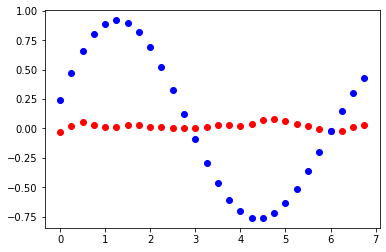

Epoch:  1


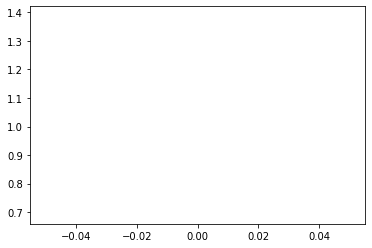

Epoch:  2


KeyboardInterrupt: ignored

In [ ]:
ShowSinPlot()
Training(40)
ShowSinPlot()

### Visualise

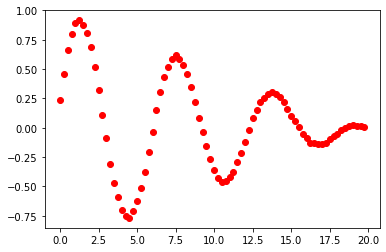

In [ ]:
  nums = np.arange(0, 20, 0.25)
  xD = []
  yD = []
  for i in range(nums.shape[0]):
    xD.append(S(nums[i]))
    yD.append(C(nums[i]))
  
  dat = np.stack((xD, yD), axis=1)
  
  plt.scatter(nums, sinGenerator.predict([dat]), c="red")
  plt.show()

#File Read

In [55]:
filenames = []
for filename in os.walk(animFilePath):
  filenames = filename[2]  

In [64]:
animFileData = []
for i in range(0, len(filenames)):
  animFileData.append(AnimFileReader(f'{animFilePath}/{filenames[i]}'))
  animFileData[i].realData = animFileData[i].realData.reshape(animFileData[i].frameCount, animFileData[i].realSize)
  animFileData[i].animData = animFileData[i].animData.reshape(animFileData[i].frameCount, animFileData[i].frameSize)
  #print(animFileData[i].realData.shape)
  #print(animFileData[i].animData.shape)


In [83]:
animData = animFileData[0].animData
realData = animFileData[0].realData

for i in range(1, len(animFileData)):
  animData = np.append(animData, animFileData[i].animData, 0)
  realData = np.append(realData, animFileData[i].realData, 0)

animData = animData.astype(float)
realData = realData.astype(float)

print(animData.shape)
print(realData.shape)

(6205, 322)
(6205, 161)


#Animation GAN Training

##Training Vars

In [84]:
batchSize = 64
iterations = 5000

In [85]:
def GeneratorAnimBatch(_size, animData):
  batch = []
  rands = np.random.randint(0, animData.shape[0], size = _size)

  for i in range(_size):
    batch.append(animData[rands[i]])
  
  return np.array(batch)

def DiscrimAnimBatch(_size, animData, realData):
  batch = []
  rands = np.random.randint(0, animData.shape[0], size = _size)

  for i in range(_size):
    a = animData[rands[i]]
    a = np.append(a, realData[rands[i]])
    batch.append(a)

  batch = np.array(batch)

  return batch


##Networks

###Generator

In [86]:
animGenerator = Sequential([
    Input(shape=(322)),
    Dense(1024, activation='relu', use_bias=True),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(161)
])

###Discriminator

In [87]:
animDiscriminator = Sequential([
    Input(shape=(483)),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

##Training Setup

In [88]:
animCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

animGenOp = tf.keras.optimizers.Adam(1e-4)
animDiscOp = tf.keras.optimizers.Adam(1e-4)

def AnimDiscLossCalculation(_realResults, _fakeResults):
  fLoss = animCrossEntropy(tf.zeros_like(_fakeResults), _fakeResults)
  rLoss = animCrossEntropy(tf.ones_like(_realResults), _realResults)
  return fLoss + rLoss

def AnimGenLossCalculation(_fakeResults):
  return animCrossEntropy(tf.ones_like(_fakeResults), _fakeResults)

In [92]:
@tf.function
def AnimTrainingStep():
  genBatch = GeneratorAnimBatch(batchSize, animData)
  realBatch = DiscrimAnimBatch(batchSize, animData, realData)

  with tf.GradientTape() as genGradTapeS, tf.GradientTape() as discGradTapeS:
    generatedBatch = animGenerator(genBatch)

    realResult = animDiscriminator(realBatch, training = True)
    fakeResult = animDiscriminator(tf.experimental.numpy.append(genBatch, generatedBatch, 1), training = True)

    genLoss = AnimGenLossCalculation(fakeResult)
    discLoss = AnimDiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTapeS.gradient(genLoss, animGenerator.trainable_variables)
    discGrads = discGradTapeS.gradient(discLoss, animDiscriminator.trainable_variables)

    animGenOp.apply_gradients(zip(genGrads, animGenerator.trainable_variables))
    animDiscOp.apply_gradients(zip(discGrads, animDiscriminator.trainable_variables))

    return discLoss, genLoss

In [94]:
def AnimTraining(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = AnimTrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)

    if(epoch > 0 and epoch % 5 == 0):
      animGenerator.save(aiOutPath)
    
    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()

##Train

Epoch:  1


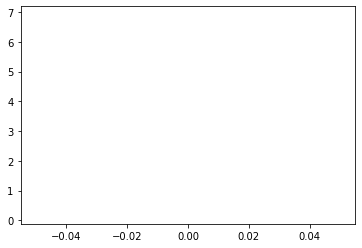

Epoch:  2


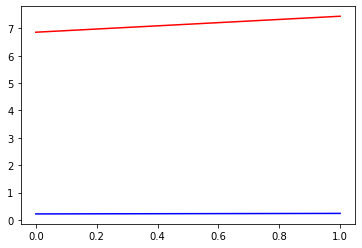

Epoch:  3


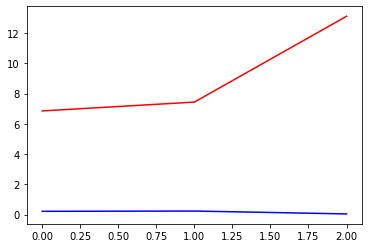

Epoch:  4


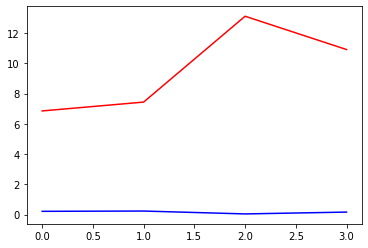

Epoch:  5


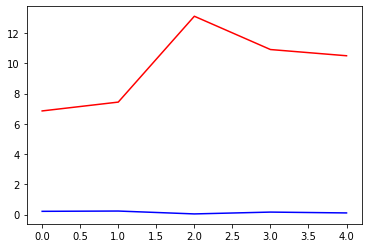

Epoch:  6
Make save here


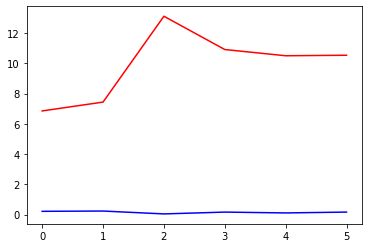

Epoch:  7


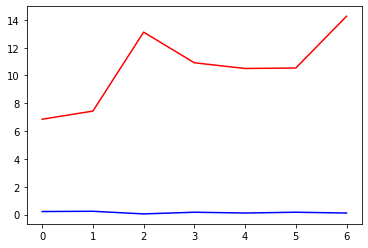

Epoch:  8


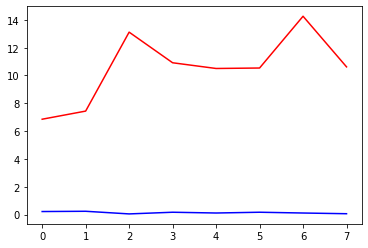

Epoch:  9


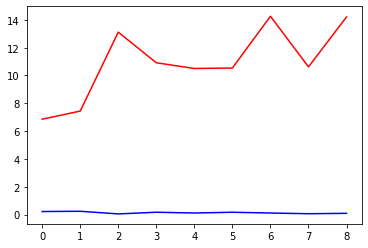

Epoch:  10


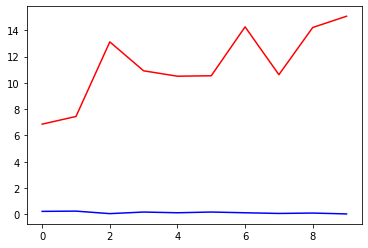

Epoch:  11
Make save here


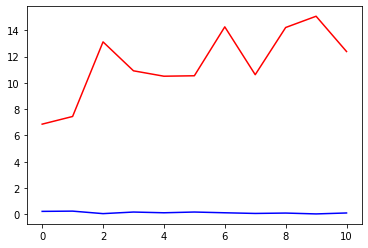

Epoch:  12


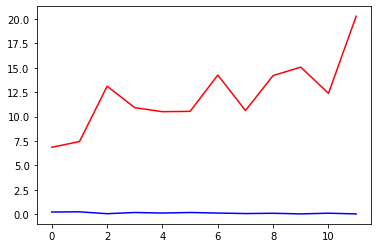

Epoch:  13


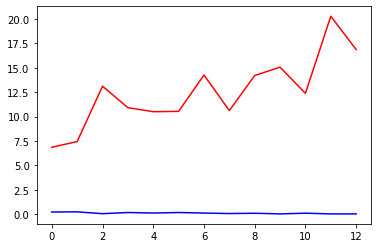

Epoch:  14


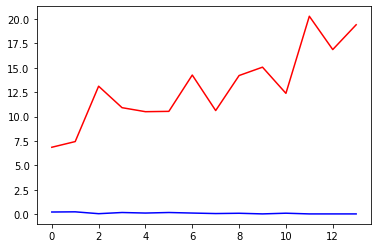

Epoch:  15


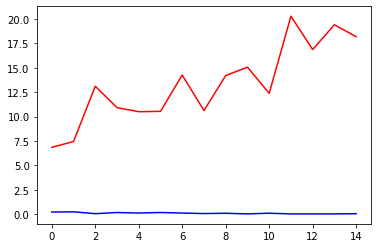

Epoch:  16
Make save here


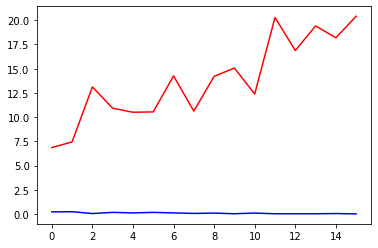

Epoch:  17


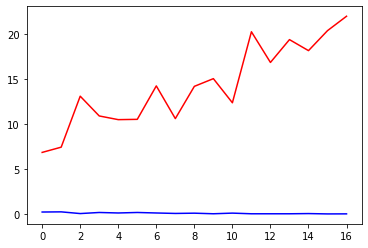

Epoch:  18


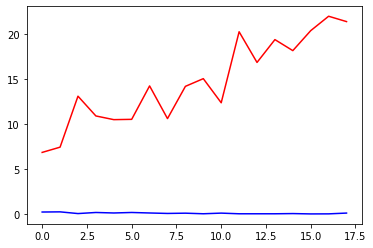

Epoch:  19


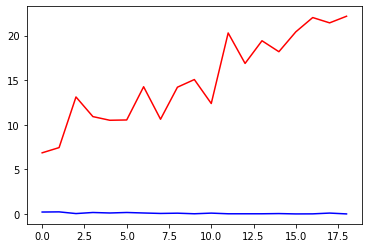

Epoch:  20


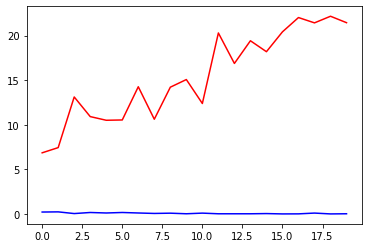

Epoch:  21
Make save here


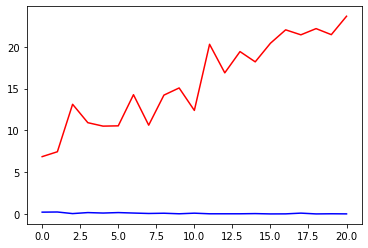

Epoch:  22


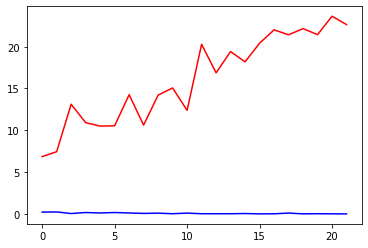

Epoch:  23


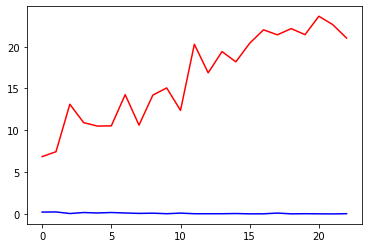

Epoch:  24


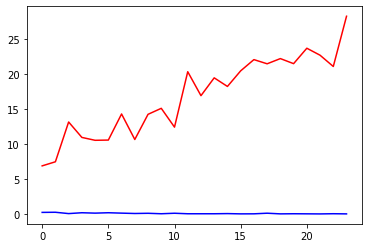

Epoch:  25


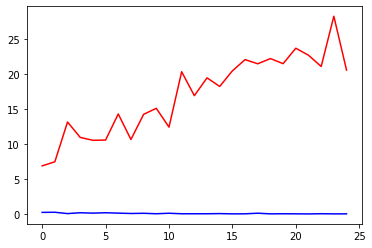

Epoch:  26
Make save here


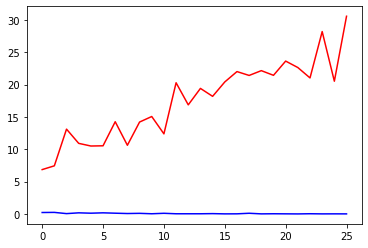

Epoch:  27


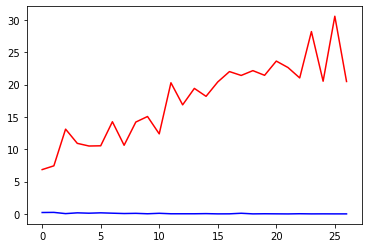

Epoch:  28


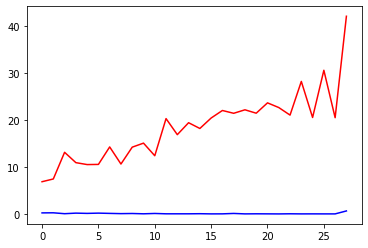

Epoch:  29


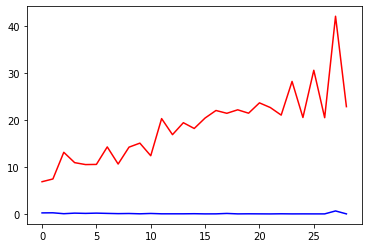

Epoch:  30


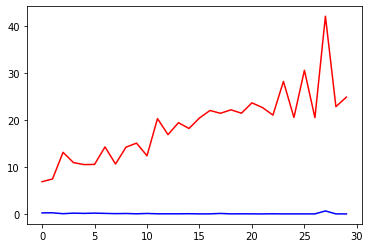

Epoch:  31
Make save here


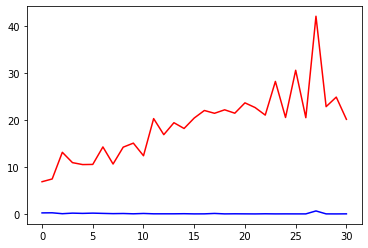

Epoch:  32


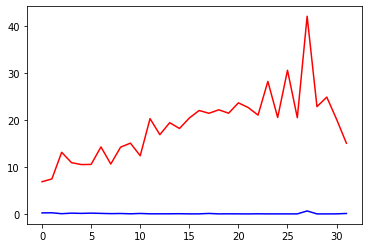

Epoch:  33


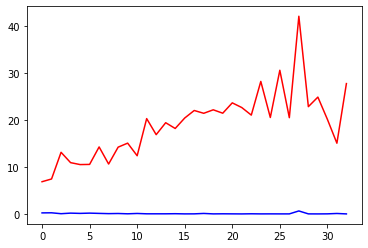

Epoch:  34


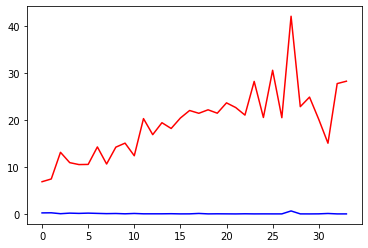

Epoch:  35


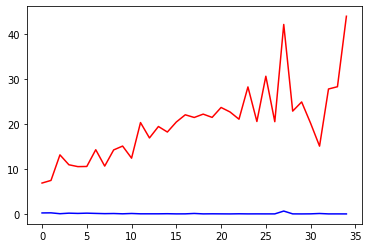

Epoch:  36
Make save here


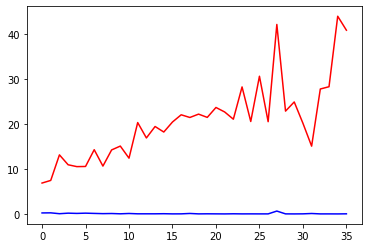

Epoch:  37


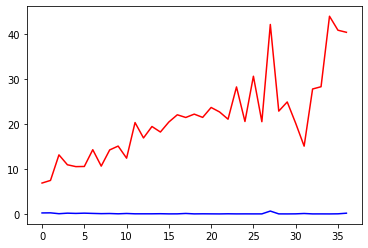

Epoch:  38


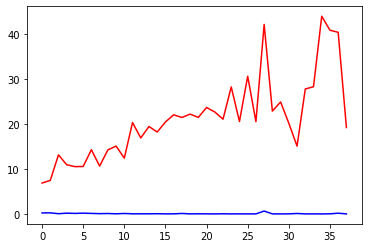

Epoch:  39


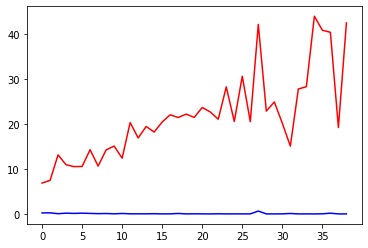

Epoch:  40


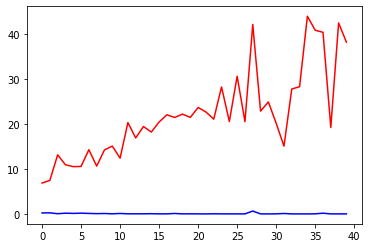

Epoch:  41
Make save here


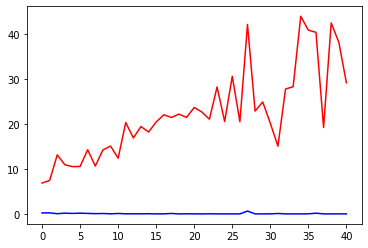

Epoch:  42


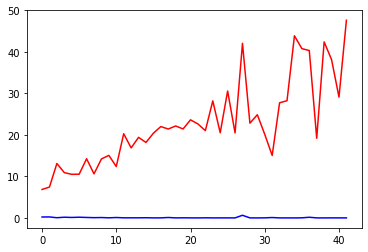

Epoch:  43


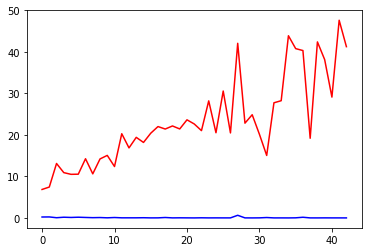

Epoch:  44


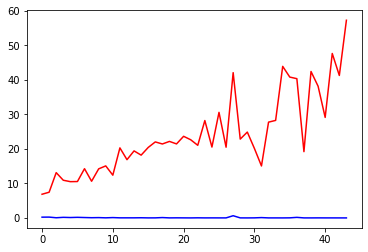

Epoch:  45


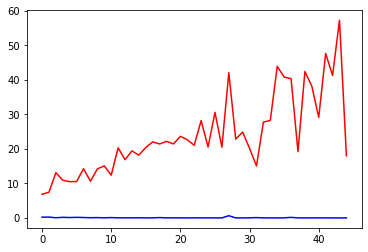

Epoch:  46
Make save here


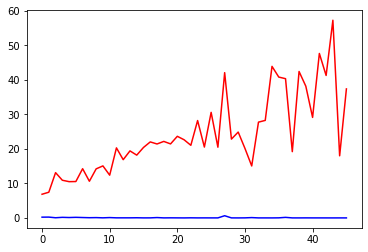

Epoch:  47


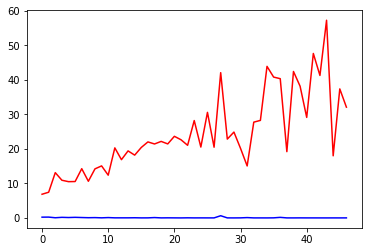

Epoch:  48


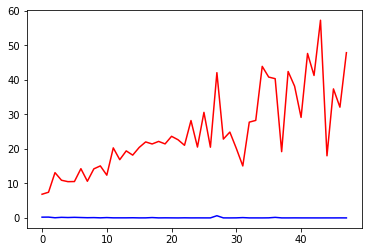

Epoch:  49


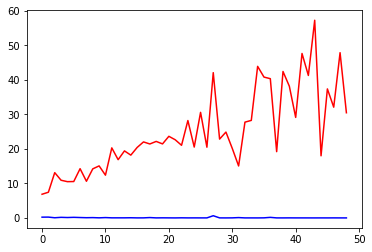

Epoch:  50


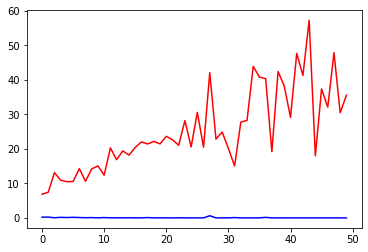

In [93]:
AnimTraining(50)